In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CM

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import pandas as pd
import numpy as np
# define column names for easy indexing
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names


In [4]:
# read data

# define filepath to read data
dir_path = '/kaggle/input/nasa-cmaps/CMaps/'

train = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv(('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])


In [5]:
test_df= test.groupby('engine').agg({'cycle':'max'})

In [6]:
y_test['cycle'] = test_df['cycle']

In [7]:
cycle=[]
for i in range(len(y_test)):
    try:
        cycle.append(y_test['RUL'][i] + y_test['cycle'][i+1])
    except:
        cycle.append(198+20)

In [8]:
test_df['cycle']= cycle

In [9]:
train_df= train.groupby('engine').agg({'cycle':'max'})

In [10]:
def add_remaining_useful_life(df, max_df):
    # Get the total number of cycles for each unit
    max_cycle= max_df['cycle']
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train,train_df)
test=add_remaining_useful_life(test,test_df)
test[index_names+['RUL']].head()

,engine,cycle,RUL
0,1,1,142.0
1,1,2,141.0
2,1,3,140.0
3,1,4,139.0
4,1,5,138.0


In [11]:
data=train.copy()

test_data=test.copy()

In [12]:
test_data['increasing']=test_data['sensor_2']+ test_data['sensor_3']+ test_data['sensor_4']+test_data['sensor_8']+test_data['sensor_13']+ test_data['sensor_15']+test_data['sensor_17']

data['increasing']=data['sensor_2']+ data['sensor_3']+ data['sensor_4']+data['sensor_8']+data['sensor_13']+ data['sensor_15']+data['sensor_17']


In [13]:
data['decreasing']=data['sensor_7']+data['sensor_12'] + data['sensor_20'] + data['sensor_21']

test_data['decreasing']=test_data['sensor_7']+test_data['sensor_12'] + test_data['sensor_20'] + test_data['sensor_21']

In [14]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['engine'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['engine']==i])
            #plt.axvline(60, color='red', linestyle='dashed', linewidth=4)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

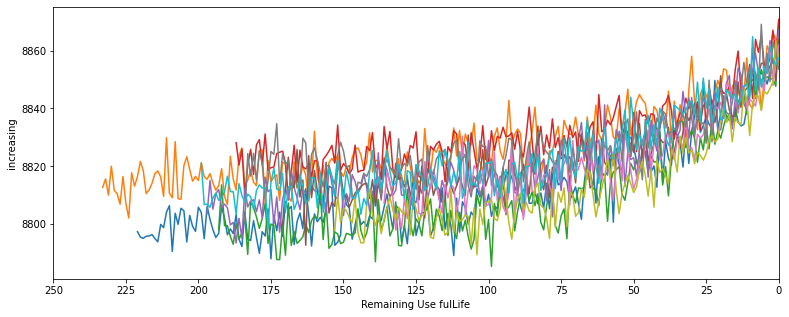

In [15]:
plot_sensor('increasing',data)

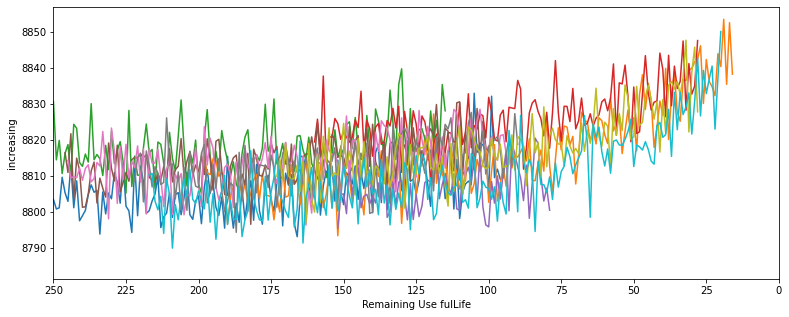

In [16]:
plot_sensor('increasing',test_data)

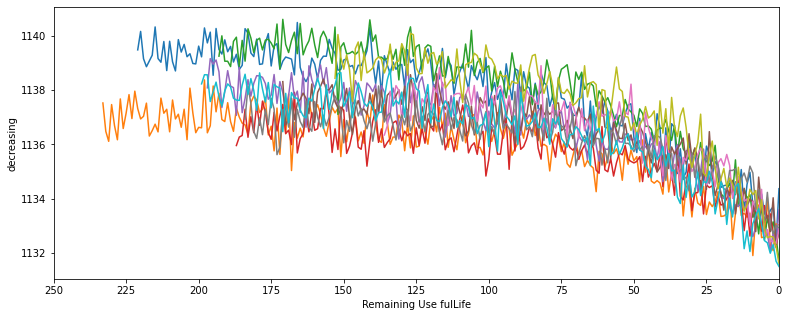

In [17]:
plot_sensor('decreasing',data)

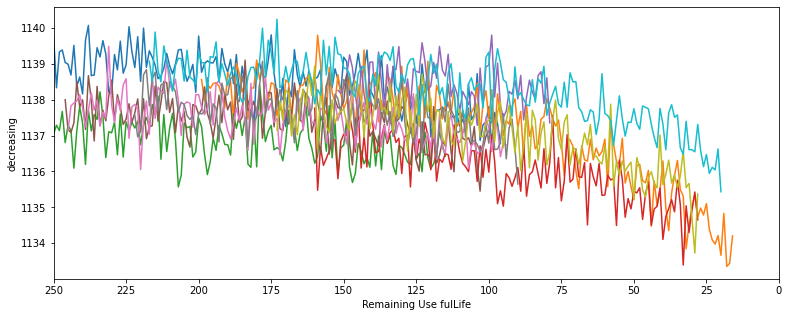

In [18]:
plot_sensor('decreasing',test_data)

In [19]:
from scipy.signal import savgol_filter

In [20]:
#Check correlation for the increasing trend sensors first

def get_correlation_plots(component,a,train_PCA,x=250,y=25):
    plt.figure(figsize=(10,4))
    for engine in train_PCA.engine.unique():
        if engine%10==0:
            data= train_PCA[train_PCA['engine']==engine]
            y1=data[component].ewm(com=0.1).mean()
            y1= savgol_filter(y1, a, 3)
            #plt.figure(figsize=(10,4))
            plt.plot(data['RUL'],y1)
            #plt.plot(random['RUL'], random['ssensor_2'])
            plt.xlim(x, 0)  # reverse the x-axis so RUL counts down to zero
            plt.xticks(np.arange(0, x, y))
            plt.ylabel('Exponential Weighted Moving Average')
            plt.xlabel('Remaining Use fulLife')
            plt.grid(True)
    plt.show()

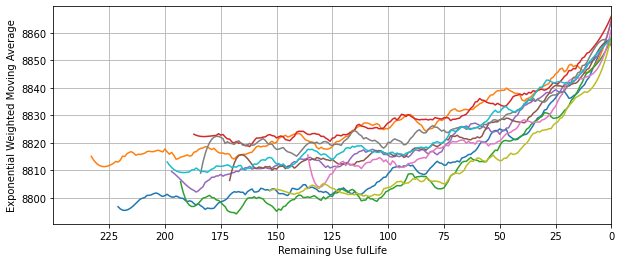

In [21]:
get_correlation_plots('increasing',21,data)

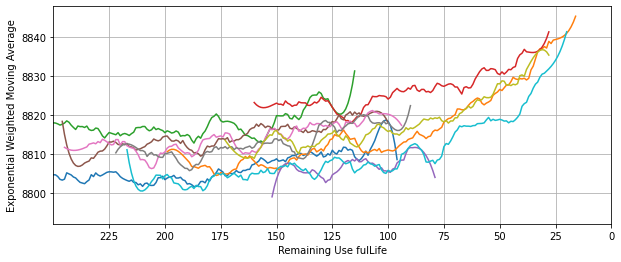

In [22]:
get_correlation_plots('increasing',21,test_data)

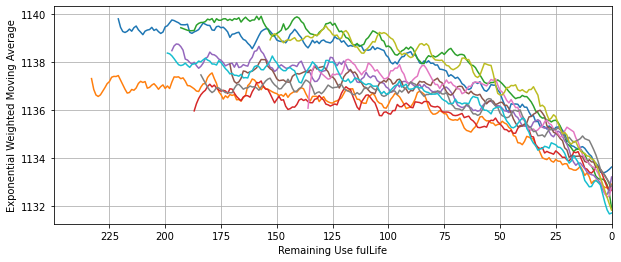

In [27]:
get_correlation_plots('decreasing',11,data)

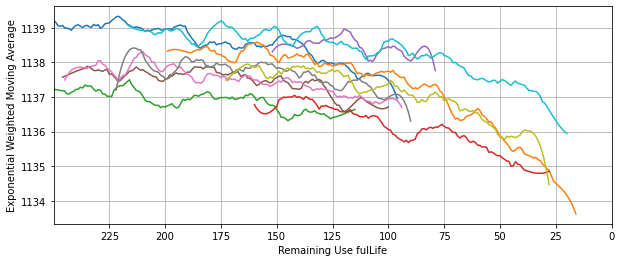

In [23]:
get_correlation_plots('decreasing',21,test_data)

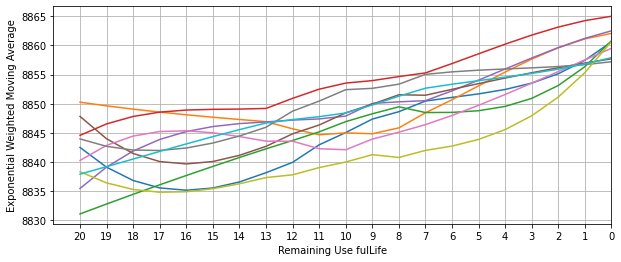

In [24]:
get_correlation_plots('increasing',15,data[data['RUL']<21],21,1)

In [25]:
corr_train=[]

for engine in data.engine.unique():
    X= data[data['engine']==engine]
    x1=X['increasing'].ewm(com=0.5).mean()
    x1= savgol_filter(x1, 27, 3)
    corr_train.append(x1)

In [26]:
corr_test=[]

for engine in test_data.engine.unique():
    data1= test_data[test_data['engine']==engine]
    y1=data1['increasing'].ewm(com=0.5).mean()
    y1= savgol_filter(y1, 27, 3)
    corr_test.append(y1)

In [27]:
def get_flat_list(comp):
    flat_list = [item for sublist in comp for item in sublist]
    return flat_list

corr_train=get_flat_list(corr_train)

corr_test=get_flat_list(corr_test)

In [28]:
data['EWM']= corr_train

test_data['EWM']=corr_test

In [34]:
data['week']= (data['RUL']/7).astype(int)

test_data['week']= (data['RUL']/7).astype(int)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'RUL for risky EWMA per week')

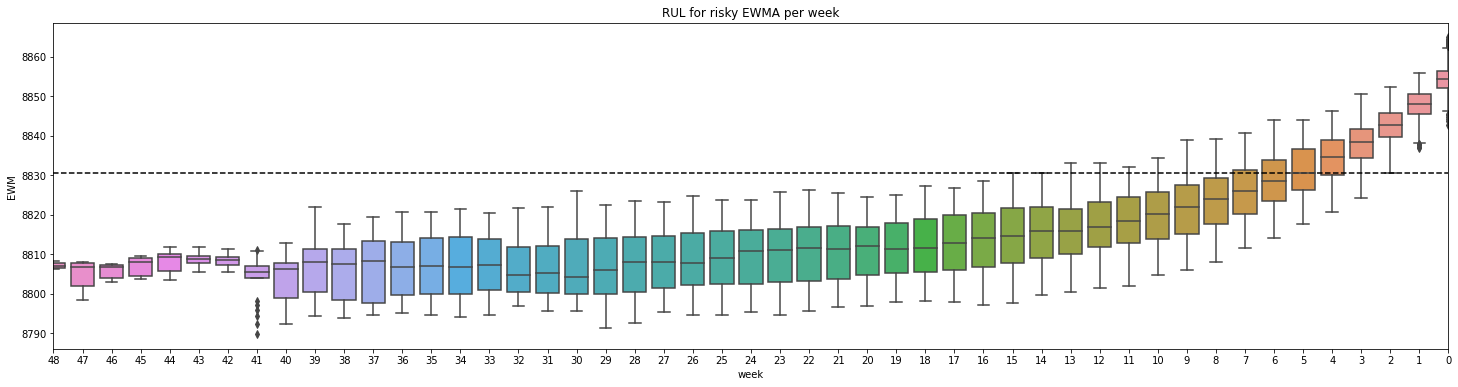

In [35]:
plt.figure(figsize=(25,6))

sns.boxplot('week','EWM',data=data)
plt.xlim(48,0)
plt.axhline(8830.59,color='black', linestyle='dashed', linewidth=1.5)

#plt.axhline(1139.63,color='black', linestyle='dashed', linewidth=1.5)
plt.title('RUL for risky EWMA per week')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'RUL for risky EWMA per week')

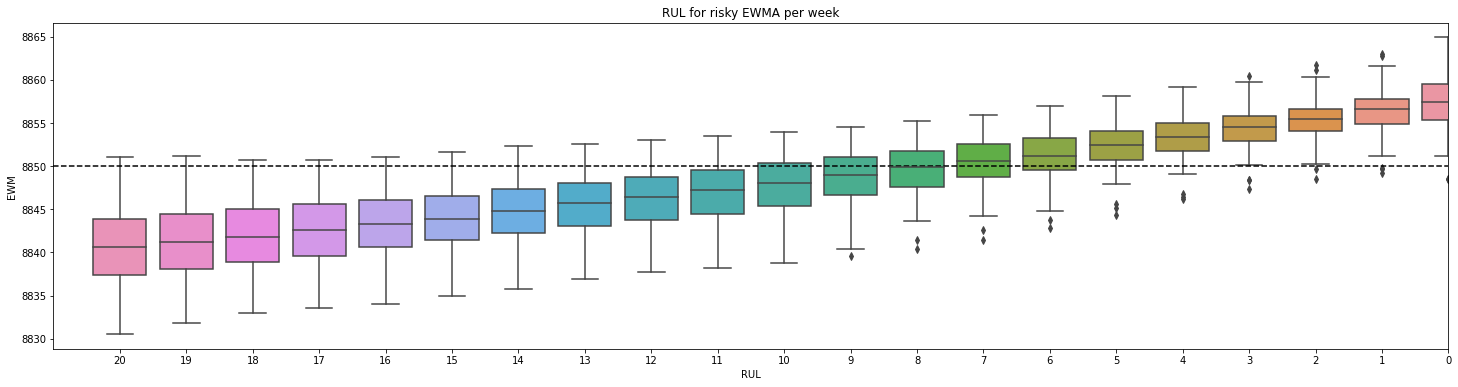

In [36]:
plt.figure(figsize=(25,6))

sns.boxplot('RUL','EWM',data=data[data['RUL']<21])
plt.xlim(21,0)
plt.axhline(8850,color='black', linestyle='dashed', linewidth=1.5)

#plt.axhline(1139.63,color='black', linestyle='dashed', linewidth=1.5)
plt.title('RUL for risky EWMA per week')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'RUL for risky EWMA per week')

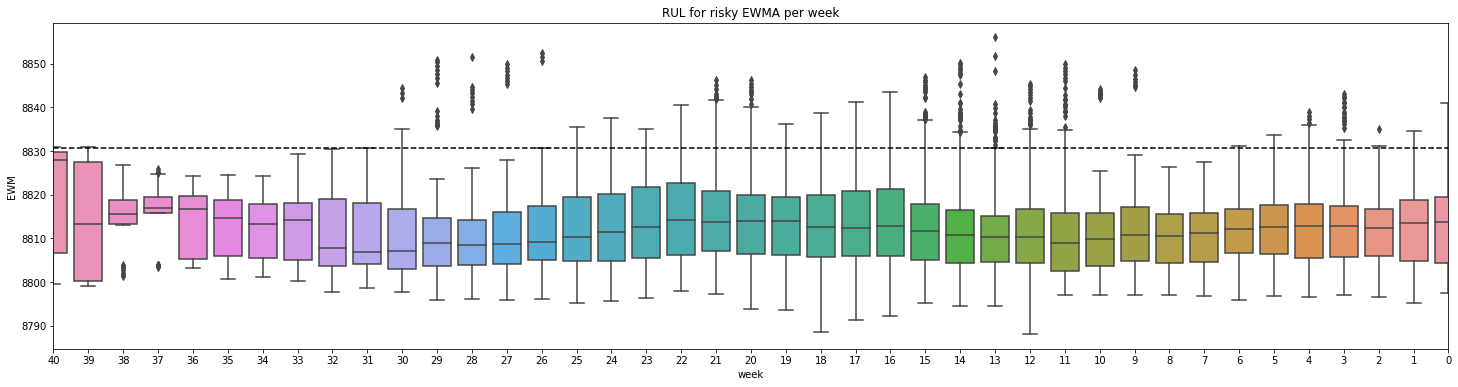

In [37]:
plt.figure(figsize=(25,6))

sns.boxplot('week','EWM',data=test_data)
plt.xlim(40,0)
plt.axhline(8830.59,color='black', linestyle='dashed', linewidth=1.5)

#plt.axhline(1139.63,color='black', linestyle='dashed', linewidth=1.5)
plt.title('RUL for risky EWMA per week')

In [29]:
data['Health']='Healthy'

test_data['Health']='Healthy'

In [30]:
def get_health(data):
    for i in range(len(data)):
        if data.loc[i,'RUL']<30:
            if data.loc[i,'EWM']>8830:
                data.loc[i,'Health']='Unhealthy'
            else:
                data.loc[i,'Health']= 'Health cannot be determined'
                cycle= data.loc[i,'cycle']
                engine= data.loc[i,'engine']
                print(f'Cannot determine health for engine cycle Check manually for Engine {engine}: Cycle {cycle}')
    #data.dropna(inplace= True)
    return data

In [31]:
data= get_health(data)

Cannot determine health for engine cycle Check manually for Engine 3: Cycle 150
Cannot determine health for engine cycle Check manually for Engine 3: Cycle 151
Cannot determine health for engine cycle Check manually for Engine 3: Cycle 152
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 160
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 161
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 162
Cannot determine health for engine cycle Check manually for Engine 4: Cycle 163
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 172
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 173
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 174
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 175
Cannot determine health for engine cycle Check manually for Engine 9: Cycle 176
Cannot determine health for engine cycle

In [32]:
test_data = get_health(test_data)

Cannot determine health for engine cycle Check manually for Engine 24: Cycle 177
Cannot determine health for engine cycle Check manually for Engine 24: Cycle 178
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 113
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 114
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 115
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 116
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 117
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 118
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 119
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 120
Cannot determine health for engine cycle Check manually for Engine 37: Cycle 121
Cannot determine health for engine cycle Check manually for Engine 41: Cycle 112
Cannot determine health for 

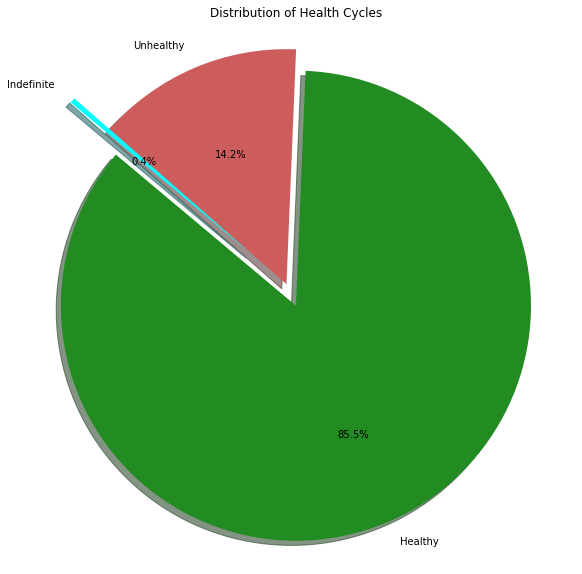

In [33]:
plt.figure(figsize=(10,10))

# Data to plot
labels= 'Healthy','Unhealthy','Indefinite'
sizes = data['Health'].value_counts()
colors = ['forestgreen','indianred','cyan']
explode = (0.1, 0,0.2)  # explode 3rd slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')

plt.title('Distribution of Health Cycles')
plt.show()

In [34]:
drop_sensor=['sensor_1',
 'sensor_5',
 'sensor_6',
 'sensor_10',
 'sensor_16',
 'sensor_18',
 'sensor_19']

In [35]:
test_data['Health'].value_counts()

Healthy                        12789
Unhealthy                        275
Health cannot be determined       32
Name: Health, dtype: int64

In [37]:
X_train_clf= data.drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health']+drop_sensor)

X_test_clf= test_data.drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health']+drop_sensor)

In [38]:
X_test_clf.columns

Index(['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_17', 'sensor_20', 'sensor_21', 'RUL', 'increasing',
       'decreasing', 'EWM'],
      dtype='object')

In [39]:
y_train_clf = data['Health']

y_test_clf= test_data['Health']

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_train_clf, y_train_clf = smote.fit_resample(X_train_clf, y_train_clf)

In [41]:
X_test_clf,y_test_clf=smote.fit_resample(X_test_clf,y_test_clf)

In [42]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_clf, y_train_clf)

KNeighborsClassifier()

In [43]:
from sklearn.metrics import recall_score,classification_report

In [44]:
print(classification_report(y_train_clf, classifier.predict(X_train_clf)))

                             precision    recall  f1-score   support

Health cannot be determined       1.00      1.00      1.00     17631
                    Healthy       1.00      0.99      1.00     17631
                  Unhealthy       0.99      1.00      1.00     17631

                   accuracy                           1.00     52893
                  macro avg       1.00      1.00      1.00     52893
               weighted avg       1.00      1.00      1.00     52893



In [45]:
print(classification_report(y_test_clf, classifier.predict(X_test_clf)))

                             precision    recall  f1-score   support

Health cannot be determined       0.96      0.69      0.81     12789
                    Healthy       0.98      1.00      0.99     12789
                  Unhealthy       0.77      0.97      0.86     12789

                   accuracy                           0.89     38367
                  macro avg       0.90      0.89      0.88     38367
               weighted avg       0.90      0.89      0.88     38367



In [46]:
X_train_reg= data[data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor)

X_test_reg= test_data[test_data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor)

In [47]:
from sklearn.feature_selection import f_regression

In [51]:
y_train_reg= data[data['Health']=='Unhealthy']['RUL']

f_scores = f_regression(X_train_reg,y_train_reg)

Text(0.5, 1.0, 'F-score  for numerical features')

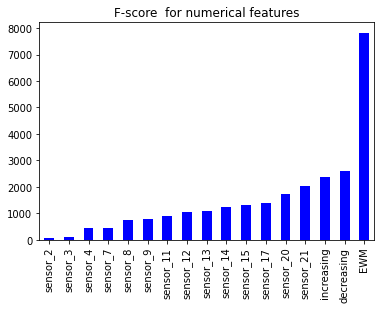

In [54]:
#The first array consists of f score-values that we need

p_series= pd.Series(f_scores[0],index= X_train_reg.columns)

p_series.plot(kind='bar',color='blue')

plt.title('F-score  for numerical features')

In [55]:
least_f=['sensor_2','sensor_3','sensor_7','sensor_8','sensor_9','sensor_11']

In [56]:
X_train_reg= data[data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor+least_f)

X_test_reg= test_data[test_data['Health']=='Unhealthy'].drop(columns=['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3','Health','RUL']+drop_sensor+least_f)

In [57]:
y_train_reg= data[data['Health']=='Unhealthy']['RUL']

y_test_reg= test_data[test_data['Health']=='Unhealthy']['RUL']

In [58]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

#Random Forest Regressor param_dict
n_estimators = [30,50,80,100,120,150]
max_depth = [4,6,8,10,12]
min_samples_split = [50,80,100,150,200]
min_samples_leaf = [10,30,40,50,60,80]
# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
# Create an instance of the random forest regressor
rf_model = RandomForestRegressor()

#RandomSearch
rf_random = RandomizedSearchCV(rf_model,param_dict,verbose=0,cv=5)
rf_random.fit(X_train_reg,y_train_reg)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [4, 6, 8, 10, 12],
                                        'min_samples_leaf': [10, 30, 40, 50, 60,
                                                             80],
                                        'min_samples_split': [50, 80, 100, 150,
                                                              200],
                                        'n_estimators': [30, 50, 80, 100, 120,
                                                         150]})

In [59]:
#Building optimal model on the best estimators
rf_optimal_model = rf_random.best_estimator_

# make predictions for test data
y_hat = rf_optimal_model.predict(X_test_reg)

In [60]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


In [61]:
rms=[]

sma=[]

model=[]

variance=[]

In [63]:
#This function calculates R2, SMAPE and RMSE for the models that we enter for test and train sets
from sklearn.metrics import mean_squared_error,r2_score
def evaluate(m,y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    var = r2_score(y_true, y_hat)
    s= smape(y_true,y_hat)
    print('{}: {} set RMSE:{}, SMAPE: {}, R Squared : {}'.format(m,label, rmse,s,var))
    rms.append(rmse)
    sma.append(s)
    model.append(m)
    variance.append(var)

In [64]:
evaluate('Random Forest Regressor',y_train_reg,rf_optimal_model.predict(X_train_reg),'train')

Random Forest Regressor: train set RMSE:3.7622916445457237, SMAPE: 31.880604211545407, R Squared : 0.8053341033367304


In [65]:
evaluate('Random Forest Regressor',y_test_reg,y_hat)

Random Forest Regressor: test set RMSE:4.002817022767533, SMAPE: 17.253420454236004, R Squared : 0.5313485446586583


In [66]:
from sklearn.linear_model import LinearRegression
# create and fit model
lm = LinearRegression()
lm.fit(X_train_reg, y_train_reg)

# predict and evaluate
y_hat_train_reg = lm.predict(X_train_reg)
evaluate('Linear Regression',y_train_reg, y_hat_train_reg, 'train')

y_hat_test = lm.predict(X_test_reg)
evaluate('Linear Regression',y_test_reg, y_hat_test)

Linear Regression: train set RMSE:4.3070841194013525, SMAPE: 36.282223672546, R Squared : 0.7448757940374234
Linear Regression: test set RMSE:4.402231113607763, SMAPE: 18.355782462856368, R Squared : 0.4331551936840301


In [67]:
from xgboost import XGBRegressor

In [68]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
xgb_model = XGBRegressor(learning_rate=0.1)

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train_reg,y_train_reg)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[08:42:28] WARNING: ../src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.3s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[08:42:28] WARNING: ../src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[08:42:29] WARNING: ../src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4, total=   0.2s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=50, max_depth=4 
[08:42:29] WARNING: ../src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   13.4s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                        

In [69]:
#Building optimal model on the best estimators
xgb_model = xgb_random.best_estimator_

In [70]:
# make predictions for test data
y_pred = xgb_model.predict(X_test_reg)

y_hat_train_reg = xgb_model.predict(X_train_reg)

In [71]:
# predict and evaluate
y_hat_train_reg = xgb_model.predict(X_train_reg)
evaluate('XGBoost Regressor',y_train_reg, y_hat_train_reg, 'train')
evaluate('XGBoost Regressor',y_test_reg, y_pred)

XGBoost Regressor: train set RMSE:3.38866839771677, SMAPE: 28.926829072665242, R Squared : 0.8420778298484385
XGBoost Regressor: test set RMSE:3.809685973228262, SMAPE: 16.191551084384127, R Squared : 0.5754812744757734


In [72]:
import lightgbm as lgb
reg = lgb.LGBMRegressor()
reg.fit(X_train_reg, y_train_reg)

LGBMRegressor()

In [73]:
# Number of trees
n_estimators = [50,80,100]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the XGBoost
lgb_model = lgb.LGBMRegressor(learning_rate=0.05)

#RandomSearch
lgb_random = RandomizedSearchCV(lgb_model,param_dict,verbose=2,cv=5)
# Maximum depth of trees
max_depth = [4,6,8]


lgb_random.fit(X_train_reg,y_train_reg)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4 
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4, total=   0.0s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4 
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4, total=   0.0s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4 
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]  n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4, total=   0.0s
[CV] n_estimators=50, min_samples_split=100, min_samples_leaf=40, max_depth=4 
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_sp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   0.1s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=40, max_depth=8 
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   0.1s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=40, max_depth=8 
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]  n_estimators=80, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   0.1s
[CV] n_estimators=80, min_samples_split=100, min_samples_leaf=40, max_depth=8 
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]  n_estimators=80

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.1s finished


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(learning_rate=0.05),
                   param_distributions={'max_depth': [4, 6, 8],
                                        'min_samples_leaf': [40, 50],
                                        'min_samples_split': [50, 100, 150],
                                        'n_estimators': [50, 80, 100]},
                   verbose=2)

In [74]:
#Building optimal model on the best estimators
lgb_model = lgb_random.best_estimator_

# make predictions for test data
y_pred_lgb = lgb_model.predict(X_test_reg)

y_hat_train_reg =  lgb_model.predict(X_train_reg)

In [75]:
# predict and evaluate
evaluate('Light GBM Regressor',y_train_reg, y_hat_train_reg, 'train')
evaluate('Light GBM Regressor',y_test_reg, y_pred_lgb)

Light GBM Regressor: train set RMSE:3.451817690090895, SMAPE: 29.2337977996458, R Squared : 0.8361370916935424
Light GBM Regressor: test set RMSE:3.8032679694551623, SMAPE: 16.05402682776955, R Squared : 0.5769104042403379


In [76]:
model=['Random Forest Regressor','Linear Regression','XGBoost Regressor','Light GBM Regressor']

In [77]:
rmse_train= []

smape_train= []

rmse_test=[]

smape_test=[]

r_train=[]

r_test=[]

for i in range(len(rms)):
    if i%2==0:
        rmse_train.append(rms[i])
        smape_train.append(sma[i])
        r_train.append(variance[i])
    else:
        rmse_test.append(rms[i])
        smape_test.append(sma[i])
        r_test.append(variance[i])

In [79]:
scores=pd.DataFrame()
scores['Model']=model
scores['RMSE Train']=rmse_train

scores['R_Squared Train']= r_train

scores['R_Squared Test']= r_test

scores['RMSE Test']= rmse_test

scores['SMAPE Train']= smape_train

scores['SMAPE Test']=smape_test

In [80]:
scores

,Model,RMSE Train,R_Squared Train,R_Squared Test,RMSE Test,SMAPE Train,SMAPE Test
0,Random Forest Regressor,3.762292,0.805334,0.531349,4.002817,31.880604,17.253420
1,Linear Regression,4.307084,0.744876,0.433155,4.402231,36.282224,18.355782
2,XGBoost Regressor,3.388668,0.842078,0.575481,3.809686,28.926829,16.191551
3,Light GBM Regressor,3.451818,0.836137,0.576910,3.803268,29.233798,16.054027


<Figure size 1440x720 with 0 Axes>

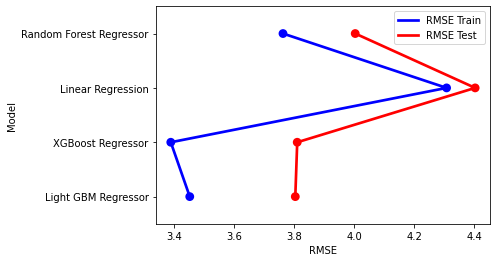

In [81]:
ax=plt.figure(figsize=(20,10))
# creating subplots
ax = plt.subplots()
# plotting columns
ax = sns.pointplot(x=scores["RMSE Train"], y=scores["Model"], color='b',alpha=0.2,labels=('RMSE SCORE TRAIN'))
ax = sns.pointplot(x=scores["RMSE Test"], y=scores["Model"], color='r',alpha=0.7,labels=('RMSE SCORE TEST'))
# renaming the axes
ax.set(xlabel="RMSE", ylabel="Model")
ax.legend(handles=ax.lines[::len(scores)+1], labels=["RMSE Train","RMSE Test"])


# visulaizing illustration
plt.show()

In [83]:
y_actual= y_test_reg.tolist()

y_pred= y_pred.tolist()

In [86]:
index=[]
for i in range (len(y_actual)):
    index.append(i)

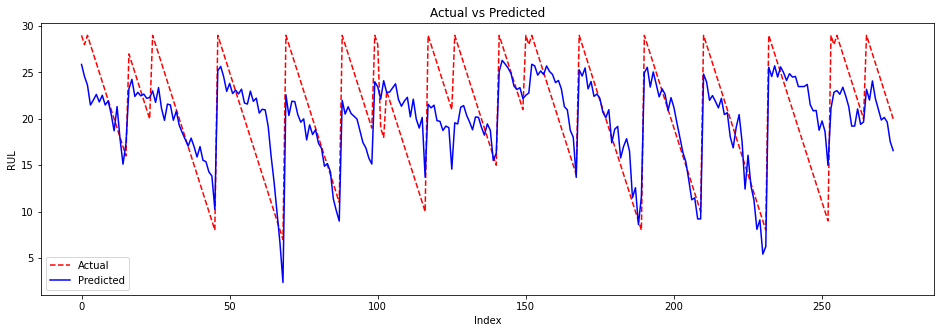

In [87]:
plt.figure(figsize=(16,5))

plt.plot(index,y_actual,color='red',linestyle='dashed')

plt.plot(index,y_pred,color='blue')

plt.ylabel('RUL')

plt.xlabel('Index')

plt.title('Actual vs Predicted')

plt.legend(['Actual','Predicted'])

In [89]:
import shap

In [90]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)
# Calculate Shap values
shap_values =shap.TreeExplainer(xgb_model).shap_values(pd.DataFrame(X_train_reg, columns=X_train_reg.columns))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


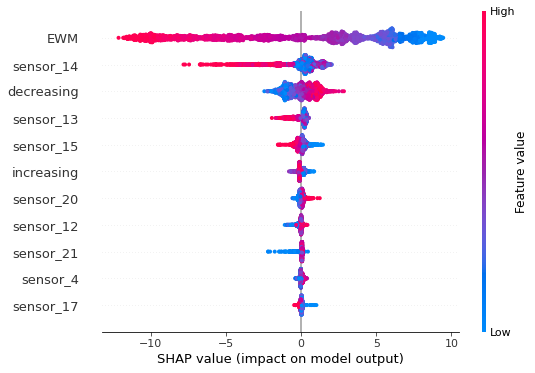

In [91]:
shap.summary_plot(shap_values, X_train_reg, feature_names=X_train_reg.columns.tolist())